<a href="https://colab.research.google.com/github/elavens/Project/blob/main/resnet50ep10for120up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define paths for the dataset
data_dir = '/content/drive/MyDrive/kaggleRDCP120/data'
batch_size = 32

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the entire dataset from Google Drive
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

In [40]:
# Calculate the sizes of train, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for train, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [41]:
# Define the ResNet-50 model
class ResNet50Custom(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Custom, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        in_features = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.resnet50(x)

# Define the model and move it to the appropriate device (GPU if available)
num_classes = len(dataset.classes)
model = ResNet50Custom(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50Custom(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [42]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Lists to store training loss and accuracy for each epoch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []


In [43]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    validation_loss = val_loss / len(val_loader)
    validation_accuracy = correct_val / total_val
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.2f}% - "
          f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {validation_accuracy*100:.2f}%")



Epoch [1/10] - Train Loss: 0.8267, Train Accuracy: 53.57% - Validation Loss: 0.5663, Validation Accuracy: 77.78%
Epoch [2/10] - Train Loss: 0.7040, Train Accuracy: 83.33% - Validation Loss: 314.4601, Validation Accuracy: 22.22%
Epoch [3/10] - Train Loss: 0.4242, Train Accuracy: 79.76% - Validation Loss: 805.4113, Validation Accuracy: 22.22%
Epoch [4/10] - Train Loss: 0.1758, Train Accuracy: 95.24% - Validation Loss: 605.3601, Validation Accuracy: 22.22%
Epoch [5/10] - Train Loss: 0.0974, Train Accuracy: 96.43% - Validation Loss: 83.3238, Validation Accuracy: 22.22%
Epoch [6/10] - Train Loss: 0.0274, Train Accuracy: 100.00% - Validation Loss: 26.7610, Validation Accuracy: 55.56%
Epoch [7/10] - Train Loss: 0.0310, Train Accuracy: 98.81% - Validation Loss: 12.1897, Validation Accuracy: 55.56%
Epoch [8/10] - Train Loss: 0.0158, Train Accuracy: 100.00% - Validation Loss: 7.6361, Validation Accuracy: 50.00%
Epoch [9/10] - Train Loss: 0.0090, Train Accuracy: 100.00% - Validation Loss: 3.0368,

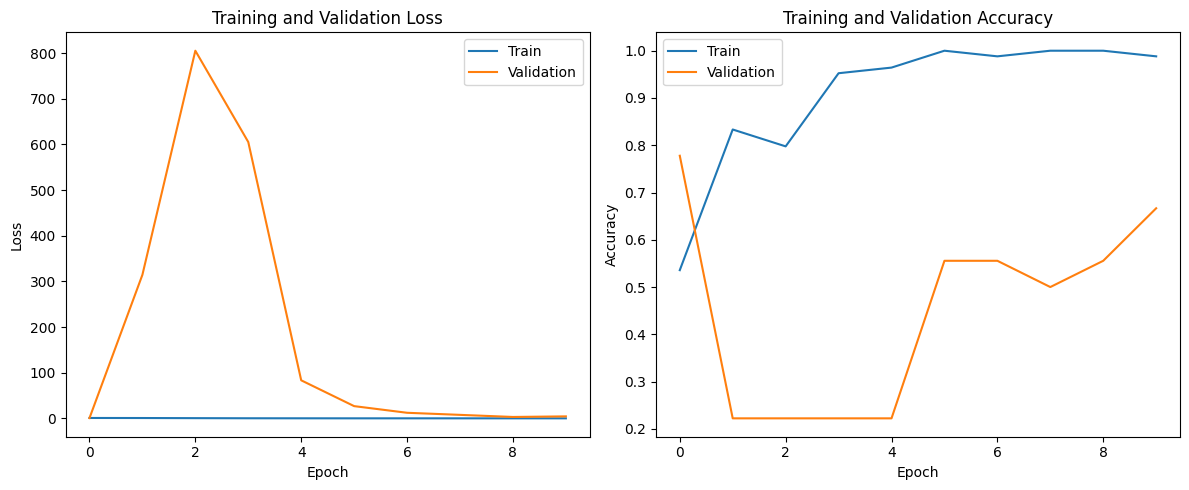

In [44]:
# Plotting the results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:


# Evaluation for each class
class_correct = [0] * num_classes
class_total = [0] * num_classes

model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        c = (predicted == labels).squeeze()
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# Print test accuracy for each class
for i in range(num_classes):
    accuracy = 100 * class_correct[i] / class_total[i]
  #  print(f"Accuracy of {dataset.classes[i]}: {accuracy:.2f}%")

# Overall test accuracy
total_correct = sum(class_correct)
total_samples = sum(class_total)
overall_accuracy = 100 * total_correct / total_samples
print(f"\nOverall Test Accuracy: {overall_accuracy:.2f}%")



Overall Test Accuracy: 66.67%


Test Accuracy: 66.67%
Precision: 0.78
Recall: 0.67
F1 Score: 0.64


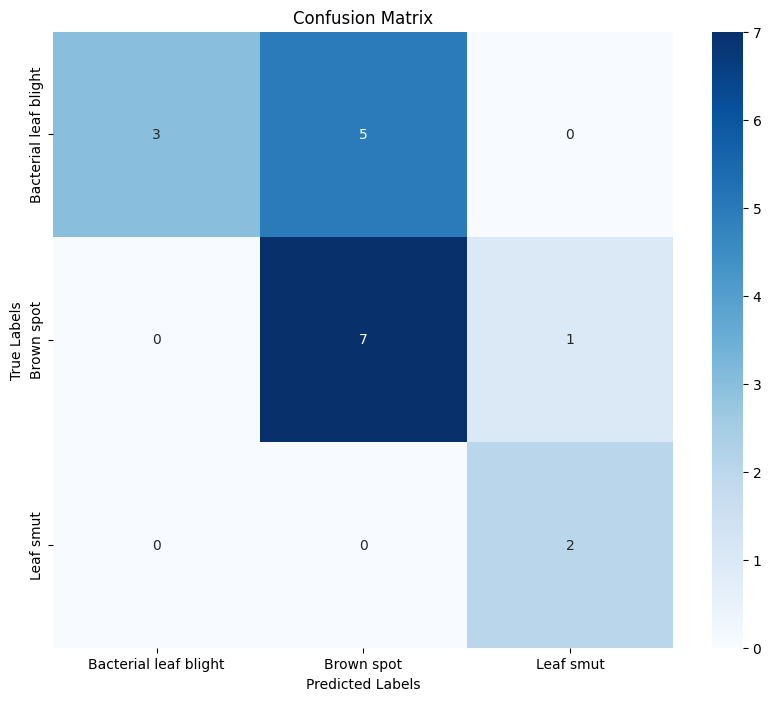

In [46]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Evaluation
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [47]:
import matplotlib.pyplot as plt
import numpy as np
from prettytable import PrettyTable

# Calculate correct, wrong predictions, and accuracy for each class
class_correct = np.array(class_correct)
class_total = np.array(class_total)
class_accuracy = class_correct / class_total * 100

# Create a table
table = PrettyTable()
table.field_names = ["Class", "Correct Predictions", "Wrong Predictions", "Accuracy"]

for i, class_label in enumerate(class_labels):
    table.add_row([class_label, class_correct[i], class_total[i] - class_correct[i], f"{class_accuracy[i]:.2f}%"])

print(table)
print(f"Test Accuracy: {accuracy*100:.2f}%")



+-----------------------+---------------------+-------------------+----------+
|         Class         | Correct Predictions | Wrong Predictions | Accuracy |
+-----------------------+---------------------+-------------------+----------+
| Bacterial leaf blight |          3          |         5         |  37.50%  |
|       Brown spot      |          7          |         1         |  87.50%  |
|       Leaf smut       |          2          |         0         | 100.00%  |
+-----------------------+---------------------+-------------------+----------+
Test Accuracy: 66.67%


In [48]:
from torchsummary import summary
import torchvision.models as models

# ...resNet50

# Print the model summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,